# DECDG Data Scientist Exercise Part I

The objective is to produce a one pager analysis of improved sanitation facilities (% of population with access). 

 ❏	How is access to sanitation facilities changing over time? 
 
 ❏	Is there an overall trend? 

 ❏	Does it vary by income group?

1)	Use the World Bank API to retrieve the people using at least basic sanitation services (% of population) (code: SH.STA.BASS.ZS) data for all countries in the WDI starting 1960. Please feel free to use any existing API client (R, Python, Stata)
2)	You most likely won’t be able to use the data as is. Conduct any data wrangling tasks you feel are necessary to transform the raw data into a usable format.
3)	Identify one a good visual display of the data that will allow a reader to easily answer the three questions mentioned above. 
4)	Produce one high quality chart that will convey this information.
5)	Summarise your findings in one short paragraph.


Using two WDI indicators
1. People using at least basic sanitation services (% of population), Series Code: SH.STA.BASS.ZS
2. Population, total, Series Code: SP.POP.TOTL

And Income groups
https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups

BY INCOME group	
Low-income economies	
Lower-middle-income economies	
Upper-middle-income economies	
High-income economies

In [1]:
# Import
import urllib
from xml.etree import ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# Extract indicator data from the API
# Indicator extracted include: "People using at least basic sanitation service", "Population, Total"
# This code could be modified to let user enter indicator IDs, so that it will work for any indicator. 

# Dictionary for indicators to be extracted
IndicatorDict = {"Sanitation":"SH.STA.BASS.ZS", "Population":"SP.POP.TOTL"}

In [3]:
# Extracted results will be saved in this dictionary
# With keys being the indicator names and values being extracted data in pandas DataFrame format
ResultDict = {}

RequestURL = 'http://api.worldbank.org/v2/country/all/indicator/'

In [4]:
for key in IndicatorDict:

    #Get total number of pages for this indicator
    DataTree = ET.parse(urllib.request.urlopen(RequestURL + IndicatorDict[key]))
    DataRoot = DataTree.getroot()
    DataPages = int(DataRoot.attrib['pages']) 
    
    DataList = []
    
    for page in range(DataPages):
        
        DataTree = ET.parse(urllib.request.urlopen(RequestURL + IndicatorDict[key] + '?page=' + str(page+1)))
        DataRoot = DataTree.getroot()
        
        for i in range(len(DataRoot)):
            DataValue = []   
            for j in range(len(DataRoot[i])):
                DataValue.append(DataRoot[i][j].text)
            #print(page, i, DataValue)
            
            DataList.append(DataValue)
   
    DataDf = pd.DataFrame(DataList)
    DataDf = DataDf.rename(columns = {0:"indicator", 1:"country", 2:"countryiso3code", 3:"date", 4:"value", 5:"unit",
                                      6:"obs_status", 7:"decimal"})
    ResultDict[key] = DataDf 
   

In [5]:
# Download Country Classification (CC) data    
CCURL = "http://databank.worldbank.org/data/download/site-content/OGHIST.xls"
urllib.request.urlretrieve(CCURL, "CountryClassification.xls")

CCDf = pd.read_excel("CountryClassification.xls", sheet_name = "Country Analytical History", skiprows = 5)
CCDf = CCDf.rename(columns = {"Unnamed: 0":"countryiso3code", "Data for calendar year :":"country"})[5:-2]

CCDf_Final = pd.DataFrame()

years = list(CCDf.columns)[2:]

for year in years:
    temp_df = CCDf[['countryiso3code','country', year]].rename(columns = {year:"Classification"})
    temp_df["date"] = [str(year)]*len(CCDf[year])
    CCDf_Final = CCDf_Final.append(temp_df)


In [6]:
# Merge different dataframes above to get data for analysis
Sanitation = ResultDict["Sanitation"]
Population = ResultDict["Population"]
FinalData = pd.merge(Sanitation[["countryiso3code", "date", "value"]], Population[["countryiso3code", "date", "value"]], 
                     how = "left", on = ["countryiso3code", "date"])
FinalData = pd.merge(FinalData, CCDf_Final, how = 'left', on = ["countryiso3code", "date"])
FinalData = pd.merge(FinalData, CCDf_Final[CCDf_Final["date"] == '2000'][['countryiso3code','Classification']], 
                     how = 'left', on = ["countryiso3code"])
FinalData = FinalData.rename(columns = {"value_x":"People using at least basic sanitation service", "value_y":"Population", 
                                        "Classification_x":"Classification_historical", 
                                        "Classification_y":"Classification_2000"})
FinalData.dropna(subset = ["People using at least basic sanitation service","Classification_historical", 
                            "Population"], inplace = True)
FinalData = FinalData.astype({"People using at least basic sanitation service":float, 'Population':int})
FinalData['Sanitation Population'] = FinalData["People using at least basic sanitation service"] * FinalData['Population']/100

In [7]:
# Rearrange data to prepare for ploting figures in two different ways
# First way, look at the trend by dynamic country classification
Rearrange_Historical = pd.DataFrame()
for date in FinalData['date'].unique():
    SumPopu = FinalData[FinalData['date'] == date].groupby("Classification_historical")["Population"].sum()
    SumSaniPopu = FinalData[FinalData['date'] == date].groupby("Classification_historical")["Sanitation Population"].sum()
    Rearrange_Historical[date] = SumSaniPopu.divide(SumPopu, fill_value = 0)


In [8]:
# Second way, look at the trend by static 2000 country classification
Rearrange_2000 = pd.DataFrame()
for date in FinalData['date'].unique():
    SumPopu = FinalData[FinalData['date'] == date].groupby("Classification_2000")["Population"].sum()
    SumSaniPopu = FinalData[FinalData['date'] == date].groupby("Classification_2000")["Sanitation Population"].sum()
    Rearrange_2000[date] = SumSaniPopu.divide(SumPopu, fill_value = 0)

Rearrange_Global = []
for date in FinalData['date'].unique():
    GlobalPopu = FinalData[FinalData['date'] == date]['Population'].sum()
    GlobalSaniPopu = FinalData[FinalData['date'] == date]['Sanitation Population'].sum()
    Rearrange_Global.append(GlobalSaniPopu/GlobalPopu)

years = FinalData['date'].unique().astype(int)

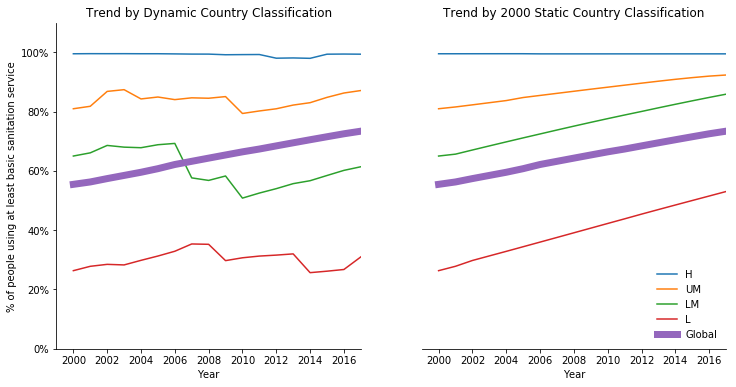

In [10]:
# Plot two subplots in one figure to compare the results
plt.figure(figsize=(12, 6))

figure1 = plt.subplot(1,2,1)
plt.plot(years, Rearrange_Historical.loc['H'], '-')
plt.plot(years, Rearrange_Historical.loc['UM'], '-')
plt.plot(years, Rearrange_Historical.loc['LM'], '-')
plt.plot(years, Rearrange_Historical.loc['L'], '-')
plt.plot(years, Rearrange_Global, '-', linewidth = 7, label = 'Global')
plt.xlabel('Year', fontsize = 10)
plt.ylabel('% of people using at least basic sanitation service', fontsize = 10)
plt.title('Trend by Dynamic Country Classification', fontsize = 12)
plt.ylim(0,1.1)
plt.xlim(1999, 2017)
figure1.spines['right'].set_visible(False)
figure1.spines['top'].set_visible(False)
vals = figure1.get_yticks()
figure1.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

figure2 = plt.subplot(1,2,2)
plt.plot(years, Rearrange_2000.loc['H'], '-')
plt.plot(years, Rearrange_2000.loc['UM'], '-')
plt.plot(years, Rearrange_2000.loc['LM'], '-')
plt.plot(years, Rearrange_2000.loc['L'], '-')
plt.plot(years, Rearrange_Global, '-', linewidth = 7, label = 'Global')
plt.xlabel('Year', fontsize = 10)
plt.title('Trend by 2000 Static Country Classification', fontsize = 12)
plt.ylim(0,1.1)
plt.xlim(1999, 2017)
plt.yticks([])
figure2.spines['right'].set_visible(False)
figure2.spines['top'].set_visible(False)
figure2.spines['left'].set_visible(False)
plt.legend(loc = 4, frameon = False, fontsize = 10)

From the above graph, it is clear that at the global level, the access to sanitation facilities improved over time – indicated by the % of people using at least basic sanitation service steadily increased from 2000 to 2017. Overall, there were still significant differences among different country income groups. The % of people using at least basic sanitation service was obviously positively related to the level of country income, with low income countries having the lowest percentage on average. However, when looking at the dynamic country income classification (figure on the left), meaning using year-on-year country income classification data and allowing countries to move among different groups from year to year, there seems to be no obvious improvement inside each income group overtime. There were even sharp drops from time to time, which was conflicting the global improving situation. It is suspected that this was due to the graduation of countries from relatively lower income groups to higher ones, and the sharp drops were caused by the graduation of relatively large countries. This suspicion is confirmed when the country income classification is made static - by using the classification in 2000 for all years (figure on the right, not allowing countries to move among groups). It is clear that, while the differences among different income groups still existed, all groups improved over time, except for high income countries which were already near 100%. The gaps between high income countries and all other income groups reduced considerably from 2000 to 2017. 